In [1]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
import requests
import random
import pickle
import re
import spacy
from spacy import displacy
import collections
from collections import Counter
from tqdm.notebook import tqdm as tqdm_notebook


nlp = spacy.load('en_core_web_trf')

In [2]:
glossary = pickle.load(open('../../data/glossaries/FNA_glossary.pkl', 'rb'))
glossary['leaf'] += ['leave']

In [3]:
#glossary_FNA['Flower']

In [4]:
compound_list = [
    'fertile', 'sterile',
    'male', 'female', 'bisexual', 'hermaphroditic', 
    'basal', 'developed', 
    'primary', 'secondary', 'main',
    'upper', 'lower', 'greater', 'dorsal', 'alternate', 'lesser', 'apex', 'outer',
    'central', 'outermost', 'outer', 'inner', 'uppermost', 'median', 'dorsal', 'central', 'lateral',
    'young', 'mature', 'individual', 
    'opposite', 'single', 'paired',
]

rubbish_list = [
    '.', ',', '-', '..', '...', '', 
]


In [5]:
data = pickle.load(open('../../data/PlantNet/descriptions_raw.pkl', 'rb'))
#data = pickle.load(open('../../data/description/04_TRAIN_0000000-0014557_PLANTS.pkl', 'rb'))

In [6]:
measurements_list = [
    'mm', 'cm', 'm', 'km',
    'milimeter', 'centimeter', 'meter', 'kilometer',
    'milimetre', 'centimetre', 'metre', 'kilometre',
    'inch', 'foot', 'yard', 'mile',
    'wide', 'long', 'broad', 'tall',
    'length', 'form',
]

In [157]:
def text_preparation(species, text):
    cleaners = [(r'(?<!\d)\.(?!\d)', ' '),
                (r'\s×\s', ' times '),
                #(r'\xa0', ' '),
                (r'\s+c\s+', ' '),
                (r'â\x80\x93', ' to '),
                (r'\xa0', ' '),
                (r'\x97', ''),
                (r'\s{2,}', ' '),
                (r'\.', ' ')]
    
    species_parts = species.split()
    candidates = [' '.join(species_parts[:idx+1]) for idx, _ in enumerate(species_parts)]
    candidates += [
        f'{species_parts[0][0]}. {species_parts[1]}'
    ]
    candidates.reverse()
    for candidate in candidates:
        try:
            text = re.sub(candidate, 'the species', text)
        except:
            continue # Skip species with brackets for now
    for (cleaner, replacement) in cleaners:
        text = re.sub(cleaner, replacement, text)    
    text = f'{text.strip()}.'
    return text.capitalize()


def dict_sentence(t):
    sentence_dict = {}
    for child in t.children:
        # Exceptions
        if (
            child.lemma_ not in rubbish_list
            #and child.lemma_ not in compound_list
            #and child.dep_ != 'compound'
            and child.dep_ not in [
                'det', 'cc',
            ]
        ):
            items = dict_sentence(child)
            sentence_dict[child] = items 
    return sentence_dict

def undict_to_tuples(d, acc = []):
    if d == {}:
        yield acc
    else:
        for k,v in d.items():
            yield from undict_to_tuples(v, acc + [k,])
            
def undict_to_pairs(d):
    for k,v in d.items():
        for subk in v:
            yield (k, subk)
        yield from undict_to_pairs(v)
    
def extract_compounds(t, doc):
    head = None
    if t.dep_ == 'compound':
        t = next(t.ancestors)
    indices = [child.i for child in t.children
               if child.dep_ == 'compound'
               or child.lemma_ in compound_list
               and child.i < t.i]
    indices.append(t.i)
    indices.sort(reverse=True)
    compounds  = []
    for idx in indices:
        compounds.append(doc[idx : t.i + 1])
    return compounds    
            
            
def check_existance(t):
    item = None
    for mainpart in glossary.keys():
        if t.lemma_ in compound_list:
            item = None
        #elif t.pos_ != 'NOUN':
        elif t.pos_ not in ['NOUN', 'PROPN']:
            item = None
        elif t.lemma_.lower().strip() in glossary[mainpart]:
            item = mainpart            
    return item


def clean_conjunctions(info_lists):
    
    new_info_lists = []
    
    for info_list in info_lists:
        new_info_list = []
        subject = info_list[0]
        new_info_list.append(subject)
        for item in info_list[1:]:
            if item.dep_ != 'conj':
                new_info_list.append(item)
            elif item.dep_ == 'conj':
                new_info_lists.append([subject, item])       
        new_info_lists.append(new_info_list)
    return new_info_lists

def clean_compounds(item_list, doc):
    new_item_list = []
    new_item_list.append(item_list[0])
    for item in item_list[1:]:
        if (
            item.lemma_ in compound_list 
            or item.dep_ == 'compound'
        ):
            continue
        elif item.pos_ == 'NOUN':
            new_item_list.append(extract_compounds(item, doc)[-1])
        else:
            new_item_list.append(item)
    return new_item_list
    
def clean_prepositions(item_list):
    
    new_item_list = []
    new_item_list.append(item_list[0])
    for item in item_list[1:]:
        if type(item) == spacy.tokens.token.Token:
            if item.dep_ == 'prep':
                if item.lemma_ in ['with']:
                    continue
                else:
                    break
                    new_item_list.append(item)
            else:
                new_item_list.append(item)
        else:
            new_item_list.append(item)
    return new_item_list

def clean_measurements(item_list):
    
    dep_list = [t.dep_ for t in item_list if type(t) == spacy.tokens.token.Token]
    new_item_list = []
    new_item_list.append(item_list[0])
    
    high = 0 
    low  = 0 
    unit = ''
    # Measurement check
    if (
        'npadvmod' in dep_list
        and 'nummod' in dep_list
        and 'quantmod' in dep_list
    ):
        amod = next(t for t in item_list[1:] if t.dep_ == 'amod')
        if amod.lemma_ == 'long' or amod.lemma_ == 'length':
            new_item_list.append('length')
        elif amod.lemma_ == 'width' or amod.lemma_ == 'wide':
            new_item_list.append('width')
        # Find high and low    
        high = next(t.lemma_ for t in item_list[1:] if t.dep_ == 'nummod')
        low  = next(t.lemma_ for t in item_list[1:] if t.dep_ == 'quantmod')
        unit = next(t.lemma_ for t in item_list[1:] if t.dep_ == 'npadvmod')
        # Define new node    
        new_item_list.append(f'{low} - {high} {unit}')
        return new_item_list
    else:
        return item_list

def create_relation(item_list):
    
    subjects = item_list[:-1]
    objects  = item_list[1:]
    relation = None
    triples = []
    
    for sub, obj in zip(subjects, objects):
        try:
            if type(sub) == spacy.tokens.span.Span:
                if obj.pos_ == 'NOUN':
                    relation = 'has_part'
                elif obj.pos_ == 'ADJ':
                    relation = 'has_property'
                else:
                    #print(sub, obj, 'create_relation')
                    relation = 'something_else'
            elif type(sub) ==  spacy.tokens.token.Token:
                if (
                    sub.pos_ == 'NOUN'
                    and obj.dep_ == 'amod'
                ):
                    relation = 'has_property'
                elif (
                    sub.pos_ == 'ADJ'
                    and obj.pos_ == 'ADJ'
                ):
                    relation = 'has_modifier'
                else:
                    relation = 'something_else'
                    #print(sub, sub.dep_)
                    #continue
            else:
                relation = 'has_property'
        except:
            relation = 'has_property'
        triples.append((sub, relation, obj))

    return triples

def extract_triples(doc):
    # Speed up the extraction
    previous = []
    
    triples = []
    for t in doc:
        part = check_existance(t)
        #print(part, t)
        if part:
            triples.append(('species', 'has_main_part', part.capitalize()))
            compound = part.capitalize()
            for new_compound in extract_compounds(t, doc):
                if type(compound) == str:
                    triples.append((compound, 'has_sub_part', new_compound.lemma_))
                else:
                    triples.append((compound.lemma_, 'has_sub_part', new_compound.lemma_))
                compound = new_compound
                #print(compound)
            # Reset T
            t = compound.root
            sentence_dict = {compound: dict_sentence(t)}
            info_lists = list(undict_to_tuples(sentence_dict))
            #print(info_lists)
            info_lists = clean_conjunctions(info_lists)
            # Retok CONJ
            #print(t, info_lists)
            for info in info_lists:
                #previous.append(info)
                #print(previous)
                info = clean_compounds(info, doc)
                info = clean_measurements(info)
                info = clean_prepositions(info)
                #print(t, info)
                triples.extend(create_relation(info))
            
    return triples

In [158]:
species_list = list(data.keys())
species = species_list[33]

In [159]:
#doc = nlp(data[species][2])
#displacy.render(doc)

In [160]:
kn_data = []
for text in tqdm_notebook(data[species][14:15]):
    text = text_preparation(species, text)
    doc = nlp(text)
    kn_data.extend(extract_triples(doc))

  0%|          | 0/1 [00:00<?, ?it/s]

In [161]:
kn_data

[('species', 'has_main_part', 'Calyx'),
 ('Calyx', 'has_sub_part', 'calyx'),
 ('species', 'has_main_part', 'Flower'),
 ('Flower', 'has_sub_part', 'sepal'),
 (sepals, 'something_else', 5),
 (sepals, 'has_property', narrow),
 (sepals, 'has_property', pubescent),
 (pubescent, 'something_else', sparsely)]

In [156]:
displacy.render(doc)

In [ ]:
type(doc[0])

# VIZ

In [132]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from netgraph import Graph
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [133]:
#descriptions

In [134]:
source   = []
relation = []
target   = []


for (sub, rel, obj) in kn_data:
    if type(sub) != str:
        sub = sub.lemma_
    if type(obj) != str:
        obj = obj.lemma_
    source.append(sub)
    relation.append(rel)
    target.append(obj)

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relation})

In [135]:
#kn_data

In [136]:
nodes = [(source, target) for source, target in zip(kg_df['source'].values, kg_df['target'].values)]
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.Graph())


node_labels = {node : node for idx, node in enumerate(G)}
edge_labels = dict(zip(list(zip(kg_df.source, kg_df.target)),
                  kg_df['edge'].tolist()))

node_size = {}
node_color = {}

size = 1.5

for node in node_labels:
    if node == 'species':
        node_size[node] = 3.5/size
        node_color[node] = 'darkgreen'
    else:
        node_size[node] = 1./size
        node_color[node] = 'white'
        
pos = nx.spring_layout(G, k = 0.08, iterations=5000, seed=3, scale=0.3, center=(0,0), dim=2)

/usr/local/anaconda3/envs/DL/lib/python3.8/site-packages/netgraph/_parser.py:19: UserWarning: Multi-graphs are not properly supported. Removing duplicate edges before plotting.
  warnings.warn(msg)


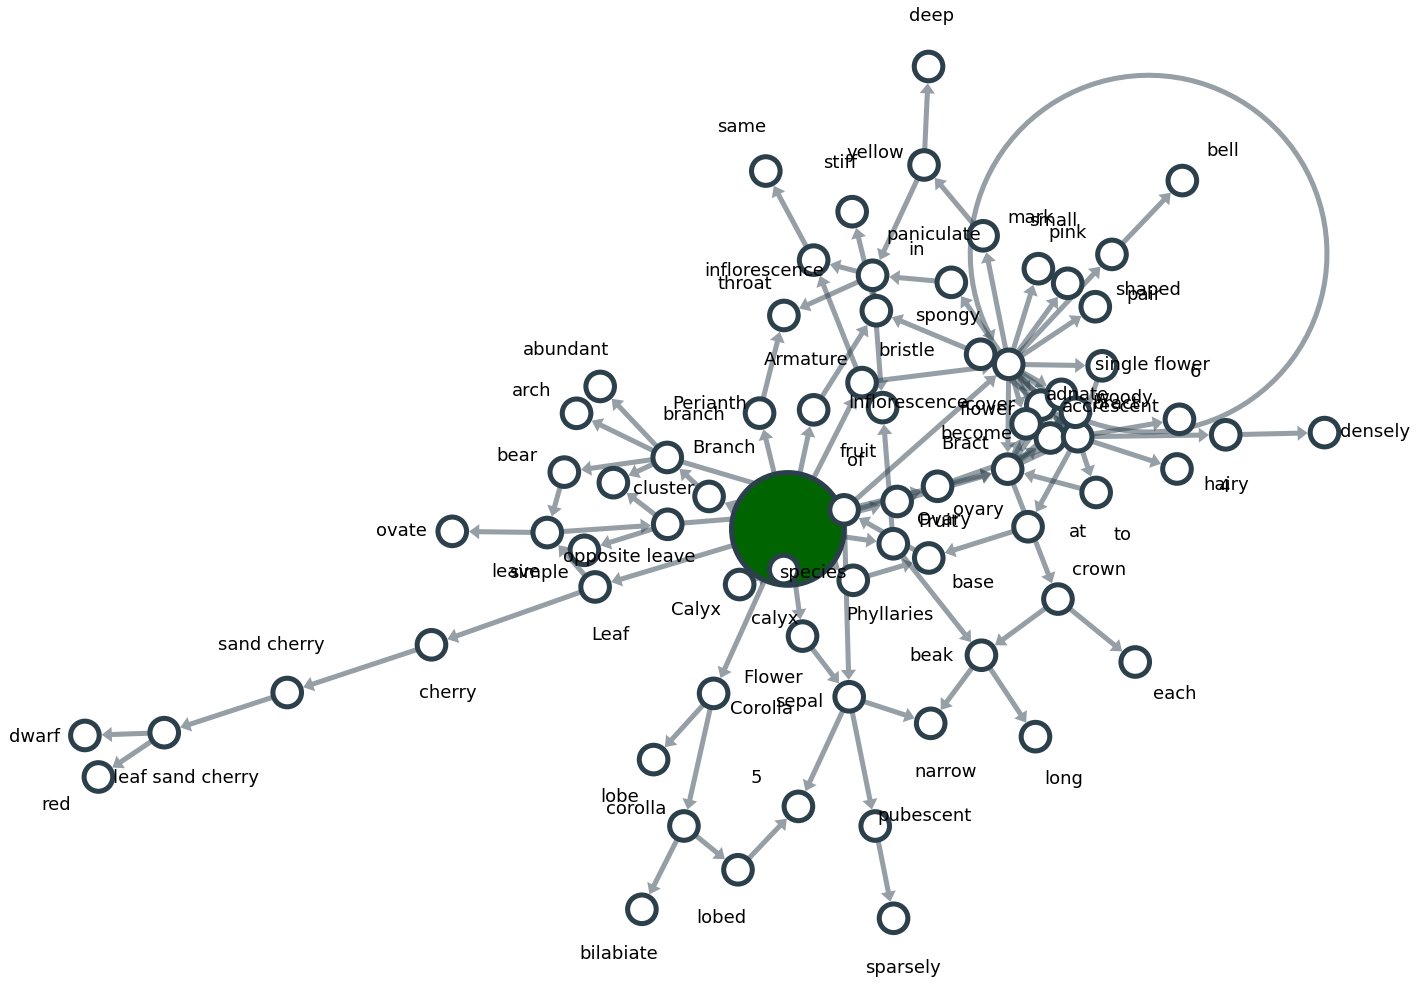

In [137]:
fig, ax = plt.subplots(figsize=(25, 25))
Graph(nodes, 
      #node_layout='spring', edge_layout='curved', 
      node_layout=pos, edge_layout='straight', 
      arrows=True, node_zorder=3, #edge_zorder=1,
      node_labels=node_labels, 
      node_label_offset=0.02, 
      #edge_labels=edge_labels,
      node_label_fontdict=dict(size=18, rotation=0, ha='center', clip_on=False), node_edge_width=0.2,
      node_size=node_size,  node_color=node_color, #edge_labels=edge_labels,
      edge_width=0.2, edge_label_fontdict=dict(size=10,),
      #node_layout_kwargs=dict(node_size=1, total_iterations=20),
      ax=ax)